In [1]:
import pandas as pd
import tensorflow as tf
import os
import numpy as np
from sklearn import metrics
from scipy.stats import zscore
from tensorflow.keras.utils import get_file
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
#from tensorflow.keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

#Kmeans clustering experiment imports
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

#tf.debugging.set_log_device_placement(True)

In [2]:
# Change me for other classifications!
# --------------------------------------------------
SCOPE = 'binary'
DATASET = 'nslkdd'
# --------------------------------------------------

# Our options to test
SCOPES = ('binary', 'categories', 'types')
DATASETS = ('kdd99', '10%kdd99', 'nslkdd')

In [3]:
'''
CONSTANTS & PROGRAM SET UP: 
To switch between binary (2), categories (5), and types (23) classifications.
'''

# Check program parameters
if SCOPE not in SCOPES:
    raise Exception(f'Please pick from available scopes: {SCOPES}. (Input: {SCOPE})')
elif DATASET not in DATASETS:
    raise Exception(f'Please pick from available datasets: {DATASETS}. (Input: {DATASET})')

# Categories
DOS_TYPES = ('back','land','neptune','pod','smurf','teardrop')
U2R_TYPES = ('buffer_overflow','loadmodule','perl','rootkit')
R2L_TYPES = ('ftp_write','guess_passwd','imap','multihop','phf','spy','warezclient','warezmaster')
PROBE_TYPES = ('ipsweep','nmap','portsweep','satan')


# For categorical conversion of outcome - dictionaries are fast
attack_dict = dict(normal ='normal')
[attack_dict.setdefault(each, 'dos') for each in DOS_TYPES]
[attack_dict.setdefault(each, 'u2r') for each in U2R_TYPES]
[attack_dict.setdefault(each, 'r2l') for each in R2L_TYPES]
[attack_dict.setdefault(each, 'probe') for each in PROBE_TYPES]


# For our methods to handle the correct number of classifications
num_classifications = {'binary' : 2, 'categories' : 5, 'types' : 23}

try:
    N_CLASS = num_classifications[SCOPE]
except KeyError as ke:
    print('Scope chosen does not match available options (check spelling)')

In [4]:
# Choose Dataset and format DF as appropriate

try:
    if DATASET == 'kdd99':
        path = get_file('kddcup.data.gz', origin='http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data.gz')
    elif DATASET == '10%kdd99':
        path = get_file('kddcup.data_10_percent.gz', origin='http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz')
    elif DATASET == 'nslkdd':
        path = './nslkdd/KDDTrain+.txt'
    else:
        raise Exception
except:
    print('Error downloading')
    raise
    
df = pd.read_csv(path, header=None)
print("Read {} rows into dataframe.".format(len(df)))

# Drop NA's (rows with missing values)
df.dropna(inplace=True,axis=1) 

columns = [
    'duration',
    'protocol_type',
    'service',
    'flag',
    'src_bytes',
    'dst_bytes',
    'land',
    'wrong_fragment',
    'urgent',
    'hot',
    'num_failed_logins',
    'logged_in',
    'num_compromised',
    'root_shell',
    'su_attempted',
    'num_root',
    'num_file_creations',
    'num_shells',
    'num_access_files',
    'num_outbound_cmds',
    'is_host_login',
    'is_guest_login',
    'count',
    'srv_count',
    'serror_rate',
    'srv_serror_rate',
    'rerror_rate',
    'srv_rerror_rate',
    'same_srv_rate',
    'diff_srv_rate',
    'srv_diff_host_rate',
    'dst_host_count',
    'dst_host_srv_count',
    'dst_host_same_srv_rate',
    'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate',
    'dst_host_serror_rate',
    'dst_host_srv_serror_rate',
    'dst_host_rerror_rate',
    'dst_host_srv_rerror_rate',
    'outcome'
]

if path == './nslkdd/KDDTrain+.txt':
    columns.append('difficulty_rating')
    
df.columns = columns


Read 125973 rows into dataframe.


In [5]:
# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd
    
# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = f"{name}-{x}"
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

# Binary Classification
def set_bin_class(df):
    for i, row in df.iterrows():
        if row['outcome'].split('.')[0] != 'normal':
            df.at[i, 'outcome'] = 1
        else:
            df.at[i, 'outcome'] = 0

# Categorical Attack Classification
def set_category_class(df):
    for i, row in df.iterrows():
        val = row['outcome'].split('.')[0]
        df.at[i, 'outcome'] = attack_dict[val]
    return    

# Supports sampling
def convert_to_numpy(df_trainer):
    # Convert to numpy - Classification
    x_columns = df_trainer.columns.drop(class_columns)
    x = df_trainer[x_columns].values
    dummies = pd.get_dummies(df_trainer['outcome']) # Classification

    outcomes = dummies.columns
    num_classes = len(outcomes)
    y = dummies.values
    return x, y, num_classes

In [6]:
# Quantitative - numeric/continuous values
to_zscore = ['duration', 'src_bytes', 'dst_bytes', 'wrong_fragment', 'urgent', 
            'hot', 'num_failed_logins', 'num_compromised', 'root_shell', 
            'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 
            'num_access_files', 'num_outbound_cmds', 'count', 'srv_count', 
            'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 
            'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 
            'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 
            'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 
            'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 
            'dst_host_srv_rerror_rate']

# Qualitative - nominal/binary features
to_dummy = ['protocol_type',
            'service',
            'flag',
            'land',
            'logged_in',
            'is_host_login',
            'is_guest_login']

# depending on the dataset we test, this handles additional classification columns
class_columns = set(columns) - set(to_zscore) - set(to_dummy)
class_columns = list(class_columns)

In [7]:
# CHECK: display 5 rows & classification counts in dataset
# print(df[0:5])
# print(df['outcome'].nunique())
# print(df.groupby('outcome')['outcome'].count())

In [8]:
# Transformations: Encode the feature vector
for each in to_zscore: encode_numeric_zscore(df, each)
for each in to_dummy: encode_text_dummy(df, each)
    
# Drop missing data
df.dropna(inplace=True,axis=1)

# Format outcome for appropriate classification
if SCOPE == 'binary': set_bin_class(df)
elif SCOPE == 'categories': set_category_class(df)
elif SCOPE == 'types': pass


# Sampling method to include all classifications of interest
num_classes = 0
while num_classes != N_CLASS: 
    x, y, num_classes = convert_to_numpy(df)

print(f'Performing {SCOPE.upper()} Classification')

Performing BINARY Classification


In [9]:
'''Create tests and training sets'''
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.25)

In [10]:
'''NEURAL NETWORK'''
def baseline_model():
    '''
    'linear' - activation takes weights*input and outputs signal proportional to the input
    'softmax' - normalized exponential activation (large input = much larger output)
    'adam' - extension to stochastic gradient descent
    '''
    model = Sequential()
    model.add(Dense(32, input_dim=x.shape[1], activation='linear'))
    model.add(Dense(32, input_dim=x.shape[1], activation='linear'))
    model.add(Dense(y.shape[1], activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

estimator = KerasClassifier(build_fn=baseline_model, epochs=5, batch_size=50, verbose=0)

In [11]:
# Train NN
from tensorflow.keras.callbacks import EarlyStopping

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
estimator.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=2,epochs=50)

Train on 94479 samples, validate on 31494 samples
Epoch 1/50
94479/94479 - 4s - loss: 0.0936 - accuracy: 0.9690 - val_loss: 0.0752 - val_accuracy: 0.9726
Epoch 2/50
94479/94479 - 3s - loss: 0.0808 - accuracy: 0.9721 - val_loss: 0.0733 - val_accuracy: 0.9722
Epoch 3/50
94479/94479 - 3s - loss: 0.0779 - accuracy: 0.9722 - val_loss: 0.0735 - val_accuracy: 0.9714
Epoch 4/50
94479/94479 - 3s - loss: 0.0777 - accuracy: 0.9720 - val_loss: 0.0709 - val_accuracy: 0.9736
Epoch 5/50
94479/94479 - 3s - loss: 0.0767 - accuracy: 0.9724 - val_loss: 0.0702 - val_accuracy: 0.9736
Epoch 6/50
94479/94479 - 3s - loss: 0.0765 - accuracy: 0.9727 - val_loss: 0.0729 - val_accuracy: 0.9732
Epoch 7/50
94479/94479 - 3s - loss: 0.0758 - accuracy: 0.9729 - val_loss: 0.0696 - val_accuracy: 0.9745
Epoch 8/50
94479/94479 - 3s - loss: 0.0754 - accuracy: 0.9728 - val_loss: 0.0696 - val_accuracy: 0.9736
Epoch 9/50
94479/94479 - 3s - loss: 0.0749 - accuracy: 0.9731 - val_loss: 0.0723 - val_accuracy: 0.9723
Epoch 10/50
94

In [12]:
# Evaluate Success of NN
import numpy as np
from sklearn import metrics

def validation_score(x, y):
    y_eval = np.argmax(y, axis=1)
    pred = estimator.predict(x)
    score = metrics.accuracy_score(y_eval, pred)
    print("Validation score: {}".format(score))
    return score

In [13]:
validation_score(x_test, y_test)

Validation score: 0.974534832031498


0.974534832031498

In [14]:
validation_score(x, y)

Validation score: 0.9742484500646964


0.9742484500646964

In [15]:
'''RANDOM FOREST'''
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=1000, n_jobs=-1, verbose=1)
rfc.fit(x_train, y_train)
predictions = rfc.predict(x_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   46.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  1.0min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    1.4s finished


In [16]:
# results = []
# for val in y:
#     results.append(val[0])

In [17]:
import warnings
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


def PCA_method(data):
    pca = PCA(n_components = 2)
    principalComponents = pca.fit_transform(data)
    principalDf = pd.DataFrame(data = principalComponents
                 , columns = [PC1, PC2])

    '''
    prepares true_normal_df for visualization; to compare against 
    the two groups generated by K-Means Clustering.
    '''
    true_normal_df = principalDf.copy()                                                     #copy PCA1, PCA2 columns from principalDf (original df) into new true_normal_df
    true_normal_df['outcome'] = df['outcome']                                               #copy outcome column from original df to true_normal_df
    true_normal_df = true_normal_df.drop(true_normal_df[true_normal_df.outcome != 0].index) #delete all rows from true_normal_df with outcome != 'normal'
    true_normal_df.drop(['outcome'], axis = 1, inplace=True)                                #drop outcome column from the true_normal_df, 
    
    return principalDf, true_normal_df


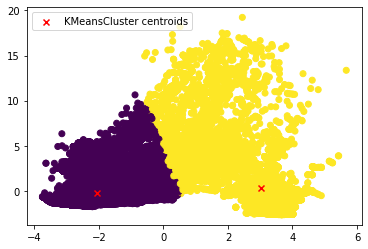

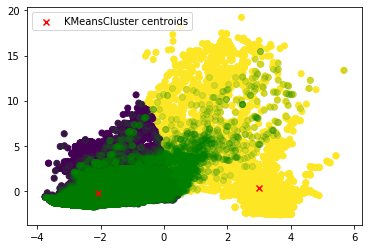

Kmeans correctly predicted 114792 out of 125973 Accuracy:  91.10000000000001 %


<Figure size 432x288 with 0 Axes>

In [18]:
### K-Means clustering on KDD99 dataset, for binary analysis (normal vs anomalous only)
if SCOPE == 'binary':
    PC1 = 'principal component 1'
    PC2 = 'principal component 2'

    x_df = df.dropna(axis=1)
    x_df = df.drop(columns=['outcome'])

    principalDf, true_normal_df = PCA_method(x_df)

    # K-Means Clustering
    km = KMeans(n_clusters = 2)
    km.fit(principalDf)
    y_kmeans = km.predict(principalDf)

    # Plot Clusters & Final Centroids
    scatter = plt.scatter(principalDf[PC1], principalDf[PC2], c = y_kmeans, cmap = 'viridis')
    centers = np.array(km.cluster_centers_)
    plt.scatter(centers[:,0], centers[:,1], marker="x", color='r', label = 'KMeansCluster centroids')
    plt.legend(loc="upper left")

    # Below we see the result of splitting the dataset into 2 clusters using KMeans Clusters.
    # On the left is normal data, on the right is anomaly data
    plt.show()

    # Save K-Means figure 1
    fname = "KMeansClusters_" + DATASET + "_" + SCOPE
    plt.savefig(fname)


    # Plot Normal Classification
    scatter = plt.scatter(principalDf[PC1], principalDf[PC2], c = y_kmeans, cmap = 'viridis')
    centers = np.array(km.cluster_centers_)
    plt.scatter(true_normal_df[PC1], true_normal_df[PC2], color = 'g', alpha = 0.15)
    plt.scatter(centers[:,0], centers[:,1], marker="x", color='r', label = 'KMeansCluster centroids')
    plt.legend(loc="upper left")
    
    # Below we see the result of splitting the dataset into 2 clusters using KMeans Clusters.
    # On the left is normal data, on the right is anomaly data.
    # We can confirm that the left is normal data by overlaying it with the values found in true_normal_df.
    plt.show()

    # Save K-Means figure 2
    fname = "KMeansClusters_Normal_"+ DATASET + "_" + SCOPE
    plt.savefig(fname)


    
    #Check accuracy of the Kmeans clustering predicted values. To do this:
    #check alignment between the y_kmeans (which are the Kmeans predicted values) and one of the two clusters. 

    #there are two possible ways that Kmeans_predicted_values could have been encoded. 1's may represent normal, or 1's may represent abnormal
    #Below, we will check both possibilites, and return the case which matches our true binary_encoded_outcome.
    binary_encoded_outcome = df['outcome'].apply(lambda x: 1 if x == 0 else 0 )

    #comparison_df will be used to compare the two possible binary encodings of "normal" from y_kmeans with the true outcome encoded in binary (called Binary_encoded_outcome)
    comparison_df = pd.DataFrame()
    comparison_df['Binary_encoded_outcome'] = binary_encoded_outcome
    comparison_df['Kmeans_predicted_A'] = y_kmeans

    #flip 0s and 1's
    comparison_df['Kmeans_predicted_B'] = comparison_df['Kmeans_predicted_A'].apply(lambda x: 0 if x == 1 else 1 ) 

    total_true_values = len(df['outcome'])

    if (comparison_df['Binary_encoded_outcome'] == comparison_df['Kmeans_predicted_A']).sum() > (comparison_df['Binary_encoded_outcome'] == comparison_df['Kmeans_predicted_B']).sum():
        principalDf['Kmeans_predicted'] = comparison_df['Kmeans_predicted_A']
    else:
        principalDf['Kmeans_predicted'] = comparison_df['Kmeans_predicted_B']

    principalDf['true_outcome'] = binary_encoded_outcome

    correctly_predicted = (principalDf['Kmeans_predicted'] == principalDf['true_outcome']).sum()
    print('Kmeans correctly predicted', correctly_predicted, 'out of', total_true_values, 'Accuracy: ', round(correctly_predicted/total_true_values, 3) * 100, '%')
